In [1]:
#data parameters
data_path = 'KNYITHAC52.csv'
test_ratio = 0.1
windows = 24
pred_step = 24
aggregate_windows = 12
target_id = 2

#model parameters
lstm_dim = 128
fc_dim = 128

#training parameters
training_state = True
learning_rate=1e-3
dropout = 0.1
batch_size = 256
num_epoch = 1000

#visualization para
test_show_num = 1000

#path para
best_model_LSTM = 'LSTM_LT.h5'

new_data.shape (8365, 26)
            0         1          2    3         4            5    6     7   \
0     0.041667 -5.875000  64.500000  0.0  0.026667  1028.755000  0.0  0.00   
1     0.119167 -6.069167  63.166667  0.0  0.000000  1029.063333  0.0  0.00   
2     0.235833 -6.139167  62.416667  0.0  0.000000  1029.488333  0.0  0.00   
3     0.031667 -5.644167  65.666667  0.0  0.000000  1029.828333  0.0  0.00   
4    -0.244167 -4.805833  71.250000  0.0  0.000000  1029.686667  0.0  0.00   
...        ...       ...        ...  ...       ...          ...  ...   ...   
8360  3.634167  2.639167  93.250000  0.0  0.000000  1010.613333  0.0  0.25   
8361  3.100833  2.435833  95.500000  0.0  0.000000  1010.386667  0.0  0.25   
8362  2.787500  1.634167  92.333333  0.0  0.000000  1009.763333  0.0  0.25   
8363  2.253333  1.254167  93.083333  0.0  0.000000  1009.621667  0.0  0.25   
8364  2.142500  1.319167  94.333333  0.0  0.040000  1009.112500  0.0  0.25   

       8         9   ...   16   17   

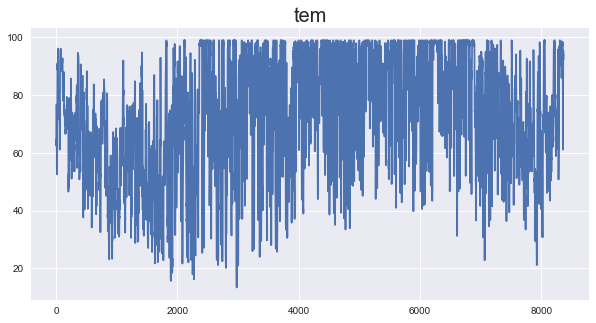



x_train.shape (7481, 24, 26)
y_train.shape (7481, 24)
x_test.shape (836, 24, 26)
y_test.shape (836, 24)


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
plt.style.use('seaborn')
#tensorflow==2.4.0 keras==2.4.3 python==3.7.10

def dataAggregate(data, aggregate_windows):
    new_data = []
    for i in range(int(len(data)/aggregate_windows)):
        new_data.append(data.values[i*aggregate_windows:(i+1)*aggregate_windows].mean(axis=-2))
    new_data=np.array(new_data)
    print('new_data.shape',new_data.shape)
    return new_data

#plot
def myPlot(array, name):
    plt.figure(figsize=(10,5))
    plt.plot(array)
    plt.title(name,fontsize='20') 
    plt.show()
    print('\n')

#minmaxscaler
def myScaler(data, target):
    mm_x= MinMaxScaler()
    mm_y= MinMaxScaler()
    data = mm_x.fit_transform(data)
    label = mm_y.fit_transform(np.reshape(target, (-1, 1)))  
    return  data, label, mm_y


def dataGenerator(data, label, test_ratio, windows, pred_step):
    data = np.array(data)
    cut = round(test_ratio* data.shape[0])
    lstm_input = []
    lstm_output = []
    for i in range(len(data)-windows-pred_step):
        lstm_input.append(data[i:i+windows,:])      
        lstm_output.append(data[i+windows:i+windows+pred_step,target_id])        
    lstm_input=np.array(lstm_input)
    lstm_output=np.array(lstm_output)  
    x_train,y_train = lstm_input[:-cut,:,:],lstm_output[:-cut:]
    x_test,y_test = lstm_input[-cut:,:,:],lstm_output[-cut:]
    print('x_train.shape',x_train.shape)
    print('y_train.shape',y_train.shape)
    print('x_test.shape',x_test.shape)
    print('y_test.shape',y_test.shape)
    return x_train, x_test, y_train, y_test

#read data
data = pd.read_csv(data_path, header=0, index_col=0)
data = data.iloc[:,1:]
data = pd.get_dummies(data)
new_data = dataAggregate(data, aggregate_windows)
new_df = pd.DataFrame(new_data)
print(new_df)
print(new_df.describe())
target = new_df.iloc[:,target_id].values

#plot y
myPlot(target, 'tem')

#scaler
data, label, mm_y = myScaler(new_df, target)

#generate data
x_train, x_test, y_train, y_test = dataGenerator(data, label, test_ratio, windows, pred_step)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 26)]          0         
                                                                 
 lstm (LSTM)                 (None, 128)               79360     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 24)                3096      
                                                                 
Total params: 98,968
Trainable params: 98,968
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
27/27 [==============================] 

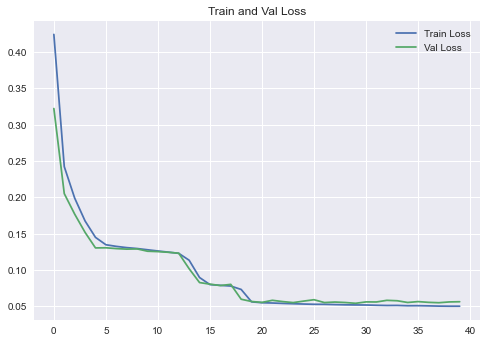

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,LSTM,Dropout,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

def lstm_model():
    inputs = Input(shape=x_train.shape[1:])
    
    lstm = LSTM(units=lstm_dim, return_sequences=False)(inputs)
    lstm = Dropout(dropout)(lstm)
    dense = Dense(fc_dim, activation="relu", use_bias=True)(lstm)
    outputs = Dense(pred_step, activation="relu", use_bias=True)(dense)
    
    model = Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse',metrics=['accuracy'])
    return model

def myTrain(myModel, training_state, Path):
    es_patience = 10
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=es_patience)
    cp = keras.callbacks.ModelCheckpoint(filepath = Path, monitor='val_loss', save_best_only=True)
    if training_state==True:
        history = myModel.fit(x= x_train,
                            y= y_train,
                            batch_size=batch_size,
                            epochs=num_epoch,
                            verbose=1,
                            callbacks=[es, cp],
                            validation_split=0.1)
        myLossPlot(history)
    myModel.load_weights(Path) 
    return myModel

def myLossPlot(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(loss))
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Val Loss')
    plt.show()

myModel = lstm_model()
myModel = myTrain(myModel, training_state, best_model_LSTM)

==============LSTM_LT Test Result===============


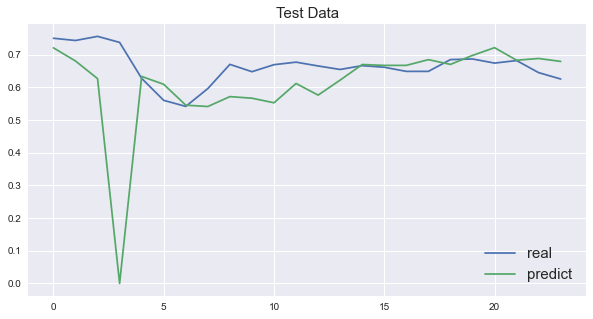

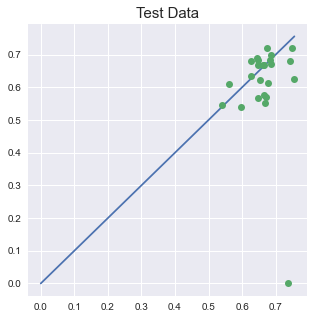

MAE     15.104434
RMSE    19.221611
MAPE          NaN
R^2           NaN
dtype: float64
==============LSTM_LT Test Result===============


In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
        
def myInverseScaler(pred, mm_y):
    pred=np.reshape(pred, (-1,1))  
    pred= mm_y.inverse_transform(pred)
    pred=pred[:,0]
    return pred

def mape(y_true, y_pred):    
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred)/y_true))/n*100
    return mape

def myResultPlot(pred, real, trainToken):
    plt.figure(figsize=(10,5))
    plt.plot(real)
    plt.plot(pred)
    plt.legend(('real', 'predict'),fontsize='15')
    plt.title("%s Data"%(trainToken),fontsize='15')
    plt.show()
    print('\n')

    plot_begin,plot_end=min(min(pred),min(real)),max(max(pred),max(real))
    plot_x=np.linspace(plot_begin,plot_end,10)
    plt.figure(figsize=(5,5))
    plt.plot(plot_x,plot_x)
    plt.plot(real,pred,'o')
    plt.title("%s Data"%trainToken,fontsize='15')
    plt.show()

def myResult(pred_list, real_list, trainToken, modelToken, mm_y):
    print('==============%s %s Result==============='%(modelToken, trainToken))
    record = []
    count = 0
    for real, pred in zip(real_list, pred_list):
        count+=1
        if count==101:
            myResultPlot(pred, real, trainToken)
        real = mm_y.inverse_transform(np.reshape(real, (-1, 1)))
        pred = mm_y.inverse_transform(np.reshape(pred, (-1, 1)))
        record2 = []
        record2.append(mean_absolute_error(real, pred))
        record2.append(np.sqrt(mean_squared_error(real, pred)))
        record2.append(None)#mape(real, pred)
        record2.append(None)#r2_score(real, pred)
        record.append(record2)
    result = pd.DataFrame(record)  
    result.columns = ['MAE','RMSE','MAPE','R^2']
    print(result.mean())      
    print('==============%s %s Result==============='%(modelToken, trainToken))
    
y_pred = myModel.predict(x_test)
myResult(pred_list = y_pred,
     real_list = y_test,
     trainToken='Test',
     modelToken='LSTM_LT',
    mm_y = mm_y
    )